<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Redes-Neurais-OCT-Images/blob/main/TCC/StratifiedKFold/OCT2017_dataset_Pre_processamento_StratifiedKFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Métodos automatizados para detectar e classificar doenças humanas a partir de imagens médicas, utilizando aprendizado profundo 

Projeto de conclusão do curso BI-MASTER na PUC-RJ

Aluna: Renata Regina da Fonseca Santos

Orientadora: Professora Evelyn Conceição


## Objetivo

Utilização de modelos de inteligência artificial pré-treinados como alternativa para predição de diagnóstico em novos exames expostos aos modelos. Itens do trabalho:

*   Análise exploratória dos dados
*   Tratamento dos dados para uso na rede neural
*   Investigar as melhores opções de configuração para o caso proposto
*   Avaliação do modelo utilizando validação cruzada




## Descrição dos dados

O dataset é composto por imagens de Tomografia de Coerência Óptica da Retina (OCT), técnica de imagem usada para capturar seções transversais de alta resolução das retinas. É organizado em 3 diretórios (train, test, val). Cada um desses diretórios contém subdiretórios para cada categoria de imagem (NORMAL, CNV, DME,DRUSEN). São 84,495 imagens (JPEG) e 4 categorias:

*   CNV (choroidal neovascularization) -  Processo patológico que consiste da formação de novos vasos sanguíneos na COROIDE.

*   DME (diabetic macular edema) - Ao longo do tempo, níveis glicêmicos altos podem levar a complicações vasculares em vários tecidos e órgãos, como no coração, sistema nervoso, rins, membros inferiores (pernas e pés) e inclusive nos olhos.

*   DRUSEN - pequenos depósitos amarelos ou brancos na retina do olho ou na cabeça do nervo óptico. A presença de drusas é um dos sinais precoces mais comuns de degeneração macular relacionada à idade.

*   NORMAL



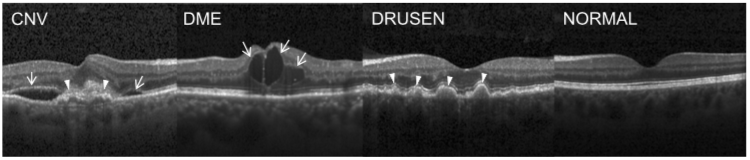

Labeled Optical Coherence Tomography (OCT) Images for Classification - Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2





### Importação das Bibliotecas

In [ ]:
### sklearn ###
from sklearn.model_selection import StratifiedKFold

### Demais Bibliotecas ###
import numpy as np
import shutil
import random
import os
import glob
import warnings

warnings.filterwarnings("ignore")
np.random.seed(0)

### Download da base do Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content/

100% 10.8G/10.8G [01:22<00:00, 175MB/s]
100% 10.8G/10.8G [01:22<00:00, 141MB/s]


In [ ]:
!unzip -o -q /content/kermany2018.zip

## Pré-Processamento - Tratamento dos dados para uso na rede neural

### Separação da base em treino e teste

As imagens nos diretórios train / val / test originais estavam repetidas, foi preciso fazer nova separação

In [ ]:
dataset_path = '/content/OCT2017 /train'
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
save_path = '/content/OCT2017 /oct_kfolds/'

if os.path.isdir(save_path):
    os.removedirs(save_path)
    os.makedirs(save_path)
else:
    os.makedirs(save_path)

In [ ]:
# Criar novos diretórios train / val / test

test_ratio = 0.10

for cls in classes:

    os.makedirs(save_path + 'train/' + cls)
    os.makedirs(save_path + 'test/' + cls)

    # Creating partitions of the data after shuffeling
    src = dataset_path + '/' + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]


    print('Total images '+ cls + ':', len(allFileNames))
    print('Training '+ cls + ':', len(train_FileNames))
    print('Testing '+ cls + ':', len(test_FileNames))
    
    # Copy-pasting images
    
    for name in train_FileNames:
        shutil.copy(name, save_path + 'train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, save_path + 'test/' + cls)                                              

Total images CNV: 37205
Training CNV: 33484
Testing CNV: 3721
Total images DME: 11348
Training DME: 10213
Testing DME: 1135
Total images DRUSEN: 8616
Training DRUSEN: 7754
Testing DRUSEN: 862
Total images NORMAL: 26315
Training NORMAL: 23683
Testing NORMAL: 2632


### Organizar nome de arquivos e classes em variáveis X e Y

In [ ]:
num_classes = len(classes)

X=[]
y=[]

train_FileNames = glob.glob(save_path +'train/*/*')

for i in range(num_classes):
    for j in range(len(train_FileNames)):  
        if classes[i] in (os.path.basename(train_FileNames[j])):
          X.append(train_FileNames[j])
          y.append(classes[i])

#train_data = pd.DataFrame({'filename':X, 'label':y})

X=np.asarray(X)
y=np.asarray(y)

### Stratified K-Fold

##### Criação de n diretórios (n_splits) com as imagens utilizando Stratified K-Fold, variação de KFold que retorna amostras estratificadas. Cada diretório tem imagens de treino e validação diferentes.

In [ ]:
foldNum = 0

skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(X, y)

for train_index, val_index in skf.split(X,y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    foldNum+=1
    print('\n','------------ Arquivos para fold',foldNum, '------------','\n')

    for cls in classes: 
        os.makedirs(save_path + 'kfold_' + str(foldNum) + '/train/' + cls)
        os.makedirs(save_path + 'kfold_' + str(foldNum) + '/val/' + cls)

        for file in X_train:
            if cls in (os.path.basename(file)):
                shutil.copy(file, save_path + 'kfold_' + str(foldNum) + '/train/' + cls + '/')
        for file in X_val:
            if cls in (os.path.basename(file)):
                shutil.copy(file, save_path + 'kfold_' + str(foldNum) + '/val/' + cls + '/')

        
        print('Training '+ cls + ':', len(glob.glob(save_path + 'kfold_' + str(foldNum) + '/train/' + cls + '/*')))
        print('Validação '+ cls + ':', len(glob.glob(save_path + 'kfold_' + str(foldNum) + '/val/' + cls + '/*')))



 ------------ Arquivos para fold 1 ------------ 

Training CNV: 22322
Validação CNV: 11162
Training DME: 6809
Validação DME: 3404
Training DRUSEN: 5169
Validação DRUSEN: 2585
Training NORMAL: 15789
Validação NORMAL: 7894

 ------------ Arquivos para fold 2 ------------ 

Training CNV: 22323
Validação CNV: 11161
Training DME: 6808
Validação DME: 3405
Training DRUSEN: 5170
Validação DRUSEN: 2584
Training NORMAL: 15788
Validação NORMAL: 7895

 ------------ Arquivos para fold 3 ------------ 

Training CNV: 22323
Validação CNV: 11161
Training DME: 6809
Validação DME: 3404
Training DRUSEN: 5169
Validação DRUSEN: 2585
Training NORMAL: 15789
Validação NORMAL: 7894


### Montar o Google Drive e mover os diretórios kfold

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True )

Mounted at /content/drive/


In [ ]:
drive_path = '/content/drive/My Drive/TCC/oct_kfolds/'

if os.path.isdir(drive_path):
    shutil.rmtree(drive_path)

In [ ]:
shutil.move(save_path, drive_path)

'/content/drive/My Drive/TCC/oct_kfolds/'

In [ ]:
drive.flush_and_unmount()